# Investigate Model

In [83]:
import os
import imp
import sys
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import keras
from keras import backend as K
from keras.preprocessing import image
from keras.utils import plot_model
from keras import models

In [2]:
#-- Set up configurations / parameters
retrain = True # retrain previously existing model
ndown = 4 # number of 'down' steps
ninit = 32 #number of channels to start with
dropout_frac = 0.2 # dropout fraction
ratio = 727 # penalization ratio for GL and non-GL points based on smaller dataaset
mod_lbl = 'atrous' #'unet'
n_test = 500
if mod_lbl == 'unet':
  mod_str = '{0}_{1}init_{2}down_drop{3:.1f}_customLossR{4}'.format(mod_lbl,ninit,ndown,
                                                        dropout_frac,ratio)
elif mod_lbl == 'atrous':
  mod_str = '{0}_{1}init_drop{2:.1f}_customLossR{3}'.format(mod_lbl,ninit,dropout_frac,ratio)
else:
  print('model label not matching.')
print(mod_str)

atrous_32init_drop0.2_customLossR727


In [3]:
#-- Directory setup
gdrive =  os.path.expanduser('~/Google Drive File Stream')
colabdir = os.path.join(gdrive,'My Drive','Colab Notebooks')
ddir = os.path.join(gdrive,'Shared drives','GROUNDING_LINE_TEAM_DRIVE','ML_Yara','geocoded_v1')
test_dir = os.path.join(ddir,'test_n%i.dir'%n_test)
output_dir = os.path.expanduser('~/GL_learning_data/')

In [4]:
#-- Get list of images
fileList = os.listdir(test_dir)

In [111]:
fname = 'gl_069_181124-181130-181206-181212_013745-024816-013920-024991_T110456_T110456_x1536_y0512_DIR11'
file_ind = fileList.index('coco_%s.npy'%fname)
im = np.load(os.path.join(test_dir,fileList[file_ind]))
h,wi,ch = im.shape

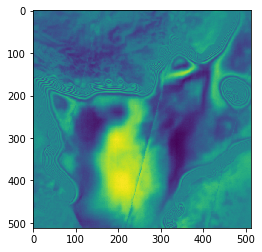

In [6]:
plt.imshow(im[:,:,0])

In [7]:
#-- Import model
mod_module = imp.load_source('unet_model',os.path.join(colabdir,'unet_model.py'))
#-- set up model
if mod_lbl == 'unet':
  print('loading unet model')
  model = mod_module.unet_model_double_dropout(height=h,width=wi,channels=ch, 
                                        n_init=ninit,n_layers=ndown,
                                        drop=dropout_frac)
elif mod_lbl == 'atrous':
  print("loading atrous model")
  model = mod_module.unet_model_atrous_double_dropout(height=h,width=wi,
                                                channels=ch,
                                                n_filts=ninit,
                                                drop=dropout_frac)
else:
  print('Model label not correct.')

loading atrous model


In [8]:
#-- define custom loss function
def customLoss(yTrue,yPred):
  return -1*K.mean(ratio*(yTrue*K.log(yPred+1e-32)) + ((1. - yTrue)*K.log(1-yPred+1e-32)))

In [9]:
#-- compile imported model
model.compile(loss=customLoss,optimizer='adam',
              metrics=['accuracy'])

In [10]:
#-- checkpoint file
chk_file = os.path.join(output_dir,'{0}_weights.h5'.format(mod_str))

#-- if file exists, read model from file
if os.path.isfile(chk_file):
  print('Check point exists; loading model from file.')
  #-- load weights
  model.load_weights(chk_file)
else:
  sys.exit('Model does not previously exist.')

Check point exists; loading model from file.


In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 608         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512, 512, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        dropout_1[0][0]                  
____________________________________________________________________________________________

In [12]:
model.layers[22]

In [13]:
im[np.newaxis, ...].shape

(1, 512, 512, 2)

In [14]:
layer_outputs = [layer.output for layer in model.layers[:22]] 
#-- extract output of first 22 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [15]:
activations = activation_model.predict(im[np.newaxis, ...]) 

In [16]:
activations[13].shape

(1, 64, 64, 128)

In [75]:
def get_axis_limits(ax):
    xinc = np.abs(ax.get_xlim()[1]-ax.get_xlim()[0])*0.05
    yinc = np.abs(ax.get_ylim()[1]-ax.get_ylim()[0])*0.12
    return ax.get_xlim()[0]+xinc, ax.get_ylim()[1]+yinc

In [116]:
#-- Set up figure
m,n = 4,4
fig,ax = plt.subplots(m,n,figsize=(10,9))
# gs1 = gridspec.GridSpec(m,n)
# gs1.update(wspace=0.0, hspace=0.0)

cmap = 'gnuplot2'
lbl = 65
bbox = dict(boxstyle="round", fc="0.8")

#-- first row: inputs
for i in [1,2]:
    ax[0,i].matshow(activations[0][0,:,:,i-1],cmap=cmap)
    ax[0,i].annotate(chr(lbl), xy=get_axis_limits(ax[0,i]),bbox=bbox)
    ax[0,i].set_aspect('equal')
    lbl += 1
    
ax[0,0].axis('off')
ax[0,3].axis('off')
ax[0,2].get_xaxis().set_visible(False)
ax[0,2].get_yaxis().set_visible(False)
ax[0,1].xaxis.set_ticks([0,len(activations[0][0,:,0,i-1])])
ax[0,1].yaxis.set_ticks([0,len(activations[0][0,0,:,i-1])])

for v,w in zip([1,2,3],[4,15,-1]):
    for i in range(n):
        ax[v,i].matshow(activations[w][0, :, :, i], cmap=cmap)
#         fig.colorbar(p,ax=ax[v,i])
        ax[v,i].annotate(chr(lbl),get_axis_limits(ax[v,i]),bbox=bbox)
        ax[v,i].set_aspect('equal')
        lbl += 1
        if i != 0:
            ax[v,i].get_xaxis().set_visible(False)
            ax[v,i].get_yaxis().set_visible(False)
        else:
            ax[v,i].xaxis.set_ticks([0,len(activations[w][0,:,0,i-1])])
            ax[v,i].yaxis.set_ticks([0,len(activations[w][0,0,:,i-1])])

#-- label rows
ax[0,1].set_ylabel('Input', size='large')
ax[1,0].set_ylabel('Layer 5', size='large')
ax[2,0].set_ylabel('Layer 16', size='large')
ax[3,0].set_ylabel('Layer 22', size='large')

# fig.suptitle('Activation Maps')
plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0.2)
plt.savefig(os.path.join(output_dir,'geocoded_v1','Test_predictions.dir',\
    '%s.dir'%mod_str,'activation_map_%s.pdf'%fname),format='PDF')
plt.close(fig)